# Test direct Jacobian matrix calculation

Flow-based generative models use invertible transformations to evaluate the density $p(x)$ at point $x$. To evalute the density, we track the determinant of the Jacobian matrix through the inverse transformation. Flow-based models also typically use transformations wtih easy-to-compute Jacobians---for example, those with triangular Jacobians---to improve scaling in high dimensions ($D^3$). 

If we only need to evalute the density at each *sampled* point $x^{(i)} \sim p(x)$, then we do not need to invert the transformation. We can track the Jacobian matrix through the forward (unnormalizing) transformation. Additionally, in GPSR, the distributions are at most six-dimensional, so it may be possible to compute the Jacobian directly without using a restricted architecture.

In [10]:
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.func import jacrev
from torch.func import vmap

import gpsr
from gpsr.beams import NNTransform

## Write vectorized function to compute Jacobians

Source: https://docs.pytorch.org/functorch/stable/generated/functorch.jacrev.html.

In [11]:
def compute_jacobian(x: torch.Tensor, function: Callable) -> torch.Tensor:
    return vmap(jacrev(function))(x)

Test on simple function.

In [12]:
def transform(x: torch.Tensor) -> torch.Tensor:
    return torch.sin(x)

x = torch.randn(64, 5)
J = compute_jacobian(x, transform)
assert J.shape == (x.shape[0], x.shape[1], x.shape[1])

## Test KL minimization with NNTransform

Use the `NNTransform` function to unnormalize samples from a base distribution. This function is not invertible, so we cannot evaluate the density at an arbitrary point. But we will try to evaluate the density at a batch of sampled points, which is all we need to estimate the KL divergence. The following example minimizes the KL divergence between the model distribution and Gaussian distribution.

In [13]:
ndim = 2
size = 10_000

class GenModel(torch.nn.Module):
    def __init__(self, transform: torch.nn.Module, base_dist: torch.distributions.Distribution) -> None:
        super().__init__()
        self.transform = transform
        self.base_dist = base_dist

    def sample(self, size: int) -> torch.Tensor:
        z = base_dist.rsample((size,))
        x = transform(z)
        return x

    def sample_and_log_prob(self, size: int) -> torch.Tensor:
        z = base_dist.rsample((size,))
        x = transform(z)
        jacobian = compute_jacobian(z, transform)
        ladj = torch.log(torch.abs(torch.linalg.det(jacobian)))
        log_prob = base_dist.log_prob(z) - ladj
        return (x, log_prob)


transform = NNTransform(
    n_hidden=2,
    width=32,
    dropout=0.0,
    activation=torch.nn.Tanh(),
    output_scale=1.0,
    phase_space_dim=ndim,
)

base_dist = torch.distributions.MultivariateNormal(
    loc=torch.zeros(ndim), 
    covariance_matrix=torch.eye(ndim),
)

prior_dist = torch.distributions.MultivariateNormal(
    loc=torch.zeros(ndim), 
    covariance_matrix=torch.eye(ndim),
)

dist = GenModel(transform, base_dist)
optimizer = torch.optim.Adam(dist.parameters(), lr=0.01)

history = {}
history["loss"] = []
for iteration in range(201):
    optimizer.zero_grad()
    x, log_prob = dist.sample_and_log_prob(size)
    entropy = -torch.mean(log_prob - prior_dist.log_prob(x))
    loss = -entropy
    loss.backward()
    optimizer.step()

    history["loss"].append(loss.item())

    if iteration % 50 == 0:
        print(iteration, loss)

0 tensor(6.1501, grad_fn=<NegBackward0>)
50 tensor(0.0566, grad_fn=<NegBackward0>)
100 tensor(0.0064, grad_fn=<NegBackward0>)
150 tensor(0.0041, grad_fn=<NegBackward0>)
200 tensor(0.0025, grad_fn=<NegBackward0>)


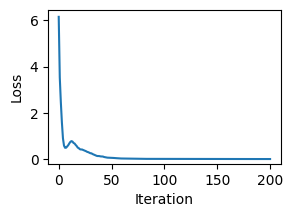

In [14]:
fig, ax = plt.subplots(figsize=(3.0, 2.0))
ax.plot(history["loss"])
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.set_ylim(-0.2, ax.get_ylim()[1])
plt.show()

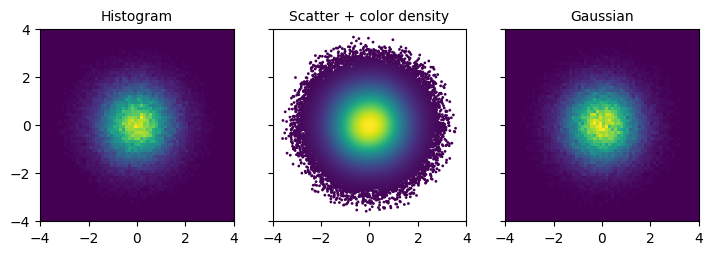

In [15]:
with torch.no_grad():
    # Sample and evaluate density at each point
    x, log_prob = dist.sample_and_log_prob(100_000)
    x = x.numpy()
    log_prob = log_prob.numpy()

    x_prior = prior_dist.rsample((x.shape[0],))

    # Sort by density
    idx = np.argsort(log_prob)
    x = x[idx]
    log_prob = log_prob[idx]

    # Plot histogram and scatter plot with points colored by density
    plot_xmax = 4.0
    plot_limits = 2 * [(-plot_xmax, plot_xmax)]

    fig, axs = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(8.5, 2.5))
    
    grid_values, grid_edges = np.histogramdd(x, bins=64, range=plot_limits, density=True)
    axs[0].pcolormesh(grid_edges[0], grid_edges[1], grid_values.T)
    axs[1].scatter(x[:, 0], x[:, 1], c=np.exp(log_prob), s=1)
    axs[2].hist2d(x_prior[:, 0], x_prior[:, 1], bins=64, range=plot_limits, density=True)
    axs[0].set_title("Histogram", fontsize="medium")
    axs[1].set_title("Scatter + color density", fontsize="medium")
    axs[2].set_title("Gaussian", fontsize="medium")
    plt.show()

### 6D

Let's try again with a 6D distribution.

In [16]:
ndim = 6
size = 10_000

transform = NNTransform(
    n_hidden=2,
    width=32,
    dropout=0.0,
    activation=torch.nn.Tanh(),
    output_scale=1.0,
    phase_space_dim=ndim,
)

base_dist = torch.distributions.MultivariateNormal(
    loc=torch.zeros(ndim), 
    covariance_matrix=torch.eye(ndim),
)

prior_dist = torch.distributions.MultivariateNormal(
    loc=torch.zeros(ndim), 
    covariance_matrix=torch.eye(ndim),
)

dist = GenModel(transform, base_dist)
optimizer = torch.optim.Adam(dist.parameters(), lr=0.01)

history = {}
history["loss"] = []
for iteration in range(201):
    optimizer.zero_grad()
    x, log_prob = dist.sample_and_log_prob(size)
    entropy = -torch.mean(log_prob - prior_dist.log_prob(x))
    loss = -entropy
    loss.backward()
    optimizer.step()

    history["loss"].append(loss.item())

    if iteration % 50 == 0:
        print(iteration, loss)

0 tensor(14.3856, grad_fn=<NegBackward0>)
50 tensor(0.3443, grad_fn=<NegBackward0>)
100 tensor(0.0761, grad_fn=<NegBackward0>)
150 tensor(0.0318, grad_fn=<NegBackward0>)
200 tensor(0.0243, grad_fn=<NegBackward0>)


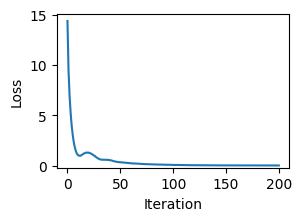

In [17]:
fig, ax = plt.subplots(figsize=(3.0, 2.0))
ax.plot(history["loss"])
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.set_ylim(-0.2, ax.get_ylim()[1])
plt.show()

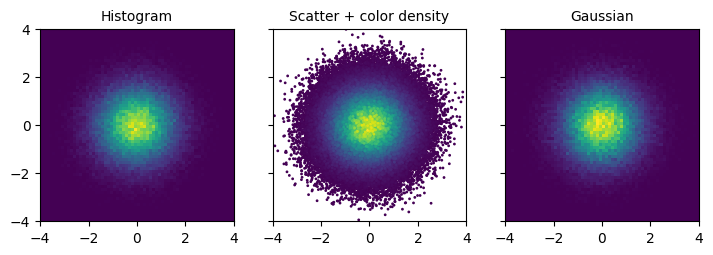

In [18]:
with torch.no_grad():
    # Sample and evaluate density at each point
    x, log_prob = dist.sample_and_log_prob(100_000)
    x = x.numpy()
    log_prob = log_prob.numpy()

    x_prior = prior_dist.rsample((x.shape[0],))

    # Sort by density
    idx = np.argsort(log_prob)
    x = x[idx]
    log_prob = log_prob[idx]

    # Plot histogram and scatter plot with points colored by density
    plot_xmax = 4.0
    plot_limits = 2 * [(-plot_xmax, plot_xmax)]

    fig, axs = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(8.5, 2.5))
    
    grid_values, grid_edges = np.histogramdd(x[:, (0, 1)], bins=64, range=plot_limits, density=True)
    axs[0].pcolormesh(grid_edges[0], grid_edges[1], grid_values.T)
    axs[1].scatter(x[:, 0], x[:, 1], c=np.exp(log_prob), s=1)
    axs[2].hist2d(x_prior[:, 0], x_prior[:, 1], bins=64, range=plot_limits, density=True)
    axs[0].set_title("Histogram", fontsize="medium")
    axs[1].set_title("Scatter + color density", fontsize="medium")
    axs[2].set_title("Gaussian", fontsize="medium")
    plt.show()